In [1]:
from pathlib import Path
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from data_processing.mapping_nbs.mapping_utils import load_mapping_data
data_dir = Path("/data/dzeiberg/mave_calibration/data")
results_dir = Path("/data/dzeiberg/mave_calibration/results_09_15_24/test_results/figs")

dataset_name = "Adamovich_BRCA1_HDR"
dataset_dir = data_dir / dataset_name
assert dataset_dir.exists()
assert results_dir.exists()

In [2]:
metadata, gene_info, gnomAD_df, spliceAI_df, clinvar_df = load_mapping_data()

In [3]:
scoreset = pd.read_csv(dataset_dir / "scoreset_processed.csv")

In [5]:
# ss2 = pd.read_csv("/data/dzeiberg/mave_calibration/data/Findlay_BRCA1_SGE/scoreset_processed.csv")

In [4]:
with open(results_dir / (dataset_name+".json")) as f:
    result = json.load(f)

In [5]:
def assign_assay_evidence_strength(score, pathogenic_score_thresholds, benign_score_thresholds):
    if np.isnan(score):
        return 0
    for threshold,points in list(zip(pathogenic_score_thresholds,[1,2,3,4,8]))[::-1]:
        if np.isnan(threshold):
            continue
        if score <= threshold:
            return points
    for threshold,points in list(zip(benign_score_thresholds,[-1,-2,-3,-4,-8]))[::-1]:
        if np.isnan(threshold):
            continue
        if score >= threshold:
            return points
    return 0

In [6]:
scoreset = scoreset.assign(assay_points=scoreset.score.apply(lambda x: assign_assay_evidence_strength(x, result['pathogenic_score_thresholds'], result['benign_score_thresholds'])))

In [7]:
def conflicting_interpretations(r):
    """
    Check if a record has conflicting interpretations
    P/LP and B/LB ; P/LP and VUS ; B/LB and VUS ; P/LP and conflicting ; B/LB and conflicting
    If data is mapped at the protein level, this could be a result of different RNA substitutions
    If data is mapped at the RNA level, this is a true conflict

    Parameters
    ----------
    r : pd.Series
        A record from the ClinVar data frame

    Returns
    -------
    bool
        True if there are conflicting interpretations, False otherwise
    """
    return r.num_p_lp > 0 and r.num_b_lb > 0 or \
            r.num_p_lp > 0 and r.num_VUS > 0 or \
            r.num_b_lb > 0 and r.num_VUS > 0 or \
            r.num_p_lp > 0 and r.num_conflicting > 0 or \
            r.num_b_lb > 0 and r.num_conflicting > 0


def is_pathogenic(r):
    return r.num_p_lp > 0 and not conflicting_interpretations(r) and r.clinvar_spliceAI_max <= .5

def is_benign(r):
    return r.num_b_lb > 0 and not conflicting_interpretations(r) and r.clinvar_spliceAI_max <= .5

def is_vus(r):
    return r.num_VUS > 0

def is_conflicting(r):
    return r.num_conflicting > 0

def is_gnomAD(r):
    try:
        return r.AF > 0 and r.spliceAI_scores <= .5
    except KeyError:
        return r.gnomAD_variants_maxAC_AF > 0 and r.gnomAD_variants_max_spliceAI_score <= .5 

def is_synonymous(r):
    return r.synonymous and r.num_p_lp == 0 and r.clinvar_spliceAI_max <= .5


In [26]:
count_df = pd.DataFrame.from_records({
    "P/LP" : scoreset.loc[(scoreset.apply(is_pathogenic, axis=1)) & (~scoreset.nonsense),'assay_points'].value_counts(),
    "B/LB" : scoreset.loc[(scoreset.apply(is_benign, axis=1)) & (~scoreset.nonsense),'assay_points'].value_counts(),
    "VUS" : scoreset.loc[(scoreset.apply(is_vus, axis=1)) & (~scoreset.nonsense),'assay_points'].value_counts(),
    "Conflicting" : scoreset.loc[(scoreset.apply(is_conflicting, axis=1)) & (~scoreset.nonsense),'assay_points'].value_counts(),
    "gnomAD" : scoreset.loc[(scoreset.apply(is_gnomAD, axis=1))& (~scoreset.nonsense),'assay_points'].value_counts(),
    "all" : scoreset.loc[~scoreset.nonsense,'assay_points'].value_counts(),
}).T.fillna(0)
for p in [-8,-4,-3,-2,-1,0, 1, 2, 3, 4, 8]:
    if p not in count_df.columns:
        count_df.loc[:,p] = 0
count_df = count_df.sort_index(axis=1)

Text(0.5, 1.0, 'Findlay BRCA1 SGE Evidence Distribution')

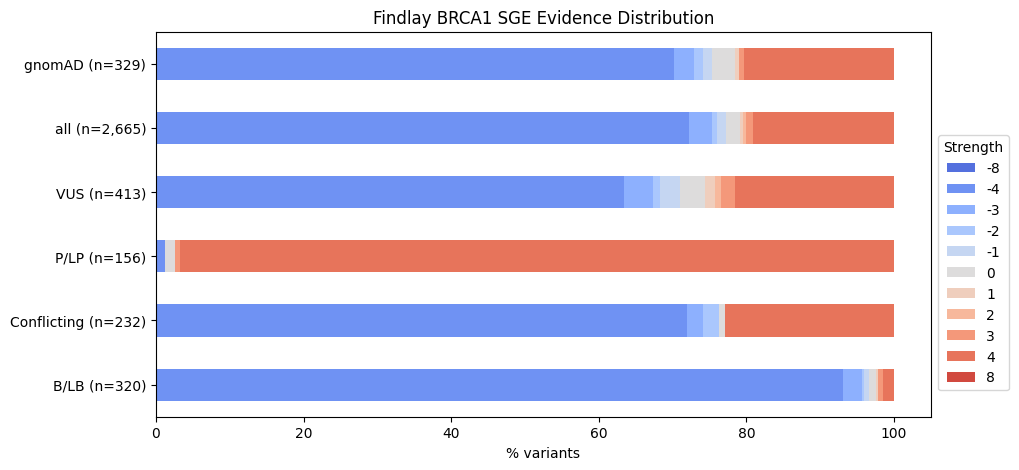

In [27]:

cp = sns.color_palette('coolwarm',n_colors=11,)#[::-1]
fig,ax = plt.subplots(1,1,figsize=(10,5))
count_df.set_index(count_df.apply(lambda x: f"{x.name} (n={int(x.sum()):,d})",axis=1)).apply(lambda x: 100 * x / x.sum(), axis=1).plot(kind='barh', stacked=True,color=cp,ax=ax)
ax.legend(title='Strength', bbox_to_anchor=(1.0, .75), loc='upper left')
ax.set_xlabel("% variants")
ax.set_title(f"{dataset_name.replace('_',' ')} Evidence Distribution")

In [10]:
alphamissense_scores = pd.read_pickle("/data/dbs/alphamissense/AlphaMissense_aa_substitutions.pkl")

In [11]:
from Bio.PDB.Polypeptide import protein_letters_3to1
def make_protein_variant(hgvs_pro):
    try:
        protein_variant = protein_letters_3to1[hgvs_pro[2:5].upper()] + hgvs_pro[5:-3] + protein_letters_3to1[hgvs_pro[-3:].upper()]
    except KeyError:
        return np.nan
    return protein_variant

def query_alphamissense_score(protein_variant,uniprot_acc):
    
    return alphamissense_scores.loc[(uniprot_acc,protein_variant),'am_pathogenicity']

In [12]:
import tqdm
tqdm.tqdm.pandas()

In [13]:
scoreset = scoreset.assign(protein_variant = scoreset.hgvs_pro_x.progress_apply(lambda x: make_protein_variant(x)))

100%|██████████| 2803/2803 [00:00<00:00, 862555.69it/s]


In [14]:
scoreset = pd.merge(scoreset, alphamissense_scores.loc[metadata.loc[dataset_name,'uniprot_acc']].am_pathogenicity, left_on='protein_variant', right_index=True, how='left',validate='m:1')

In [15]:
ALPHAMISSENSE_THRESHOLDS = dict(pathogenic_score_thresholds=[.792, .906, .972, .990, np.nan],
                                benign_score_thresholds=[.169, .099, .070, np.nan, np.nan])
def assign_AlphaMissense_strength(score):
    if np.isnan(score):
        return 0
    for threshold,points in zip(ALPHAMISSENSE_THRESHOLDS['pathogenic_score_thresholds'][::-1],[8,4,3,2,1]):
        if np.isnan(threshold):
            continue
        if score >= threshold:
            return points
    for threshold,points in zip(ALPHAMISSENSE_THRESHOLDS['benign_score_thresholds'][::-1],[-8,-4,-3,-2,-1]):
        if np.isnan(threshold):
            continue
        if score <= threshold:
            return points
    return 0

In [16]:
scoreset = scoreset.assign(AlphaMissense_points=scoreset.am_pathogenicity.apply(assign_AlphaMissense_strength))

In [17]:
# cp = sns.choose_colorbrewer_palette('diverging',)
cp = sns.color_palette('coolwarm',n_colors=11,)#[::-1]

Text(0.5, 1.0, 'AlphaMissense Evidence Distribution')

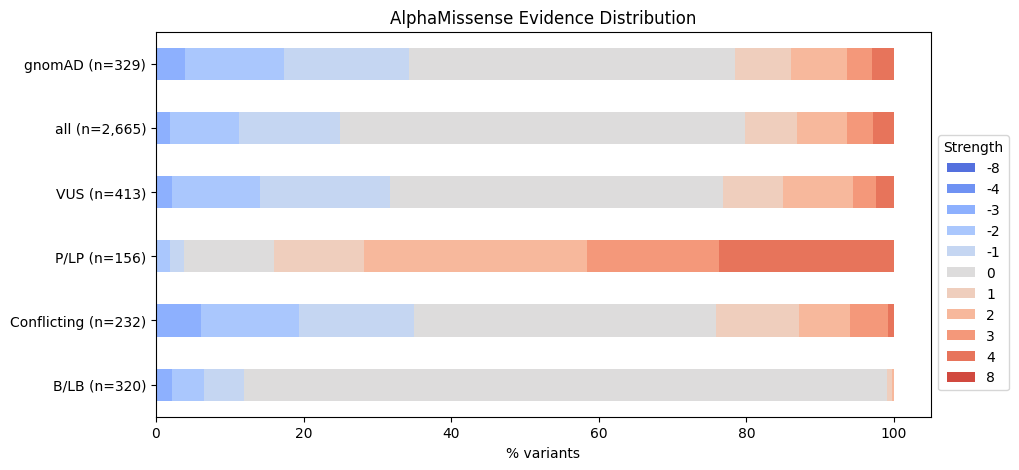

In [28]:
alphaMissense_count_df = pd.DataFrame.from_records({
    "P/LP" : scoreset.loc[(scoreset.apply(is_pathogenic, axis=1)) & (~scoreset.nonsense),'AlphaMissense_points'].value_counts(),
    "B/LB" : scoreset.loc[(scoreset.apply(is_benign, axis=1)) & (~scoreset.nonsense),'AlphaMissense_points'].value_counts(),
    "VUS" : scoreset.loc[(scoreset.apply(is_vus, axis=1)) & (~scoreset.nonsense),'AlphaMissense_points'].value_counts(),
    "Conflicting" : scoreset.loc[(scoreset.apply(is_conflicting, axis=1)) & (~scoreset.nonsense),'AlphaMissense_points'].value_counts(),
    "gnomAD" : scoreset.loc[(scoreset.apply(is_gnomAD, axis=1))& (~scoreset.nonsense),'AlphaMissense_points'].value_counts(),
    "all" : scoreset.loc[~scoreset.nonsense,'AlphaMissense_points'].value_counts(),
}).T.fillna(0)
for p in [-8,-4,-3,-2,-1,0, 1, 2, 3, 4, 8]:
    if p not in alphaMissense_count_df.columns:
        alphaMissense_count_df.loc[:,p] = 0
alphaMissense_count_df = alphaMissense_count_df.sort_index(axis=1)
fig,ax = plt.subplots(1,1,figsize=(10,5))
alphaMissense_count_df.set_index(alphaMissense_count_df.apply(lambda x: f"{x.name} (n={int(x.sum()):,d})",axis=1)).apply(lambda x: 100 * x / x.sum(), axis=1).plot(kind='barh', stacked=True,
                                                                                                                                                                   color=cp,ax=ax)
ax.legend(title='Strength', bbox_to_anchor=(1.0, .75), loc='upper left')
ax.set_xlabel("% variants")
ax.set_title("AlphaMissense Evidence Distribution")

In [30]:
scoreset = scoreset.assign(PM2_points = (scoreset.AF > 0).astype(int))
scoreset = scoreset.assign(total_points = scoreset.PM2_points + scoreset.AlphaMissense_points + scoreset.assay_points)

In [31]:
scoreset[scoreset.num_p_lp > 0].loc[:,['assay_points','AlphaMissense_points','PM2_points','total_points']].value_counts().sort_index()

assay_points  AlphaMissense_points  PM2_points  total_points
-4            -2                    0           -6                1
              -1                    0           -5                1
 0             2                    1            3                1
               4                    0            4                1
 3            -1                    0            2                1
 4            -2                    0            2                4
              -1                    0            3                1
               0                    0            4              115
                                    1            5                5
               1                    0            5               19
                                    1            6                6
               2                    0            6               36
                                    1            7               12
               3                    0            7     

In [32]:
scoreset[scoreset.num_b_lb > 0].loc[:,['assay_points','AlphaMissense_points','PM2_points','total_points']].value_counts().sort_index()

assay_points  AlphaMissense_points  PM2_points  total_points
-4            -3                    0           -7                5
                                    1           -6                2
              -2                    0           -6               11
                                    1           -5                2
              -1                    0           -5               11
                                    1           -4                6
               0                    0           -4              249
                                    1           -3               11
               1                    0           -3                2
-3             0                    0           -3                7
               2                    0           -1                1
-2             0                    0           -2                1
-1             0                    0           -1                2
 0             0                    0            0     

In [34]:
scoreset.loc[scoreset.num_VUS > 0,['assay_points','AlphaMissense_points','PM2_points','total_points']].value_counts().sort_index(level=3)

assay_points  AlphaMissense_points  PM2_points  total_points
-4            -3                    0           -7               8
                                    1           -6               1
              -2                    0           -6              28
                                    1           -5              12
              -1                    0           -5              51
-3            -2                    0           -5               2
-4            -1                    1           -4              12
               0                    0           -4              90
-3            -1                    0           -4               1
-4             0                    1           -3              27
               1                    0           -3              11
-3            -1                    1           -3               1
               0                    0           -3               6
-1            -2                    0           -3               2
-

In [98]:
point_cutoffs = dict(pathogenic=10,likely_pathogenic=6,likely_benign=-1,benign=-7)

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = ["A1", "A2", "B1", "B2", "C1", "C2"],
      color = "blue"
    ),
    link = dict(
      source = [0, 1, 0, 2, 3, 3], # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = [2, 3, 3, 4, 4, 5],
      value = [8, 4, 2, 8, 4, 2]
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show()